# Table of Contents
[1 Load Data](#1)
    
[2 Exploratory Data Analysis](#2)

[3 Data Pre-Processing](#3)
- [3.1 Data Clean-up](#3.1)
- [3.2 Merge dataframes](#3.2)
- [3.3 Remove reviews and movies that do not have plot synopsis](#3.3)

[4 Feature Engineering](#4)

- [4.1 Review Word Count](#4.1)
- [4.2 Review Rating](#4.2)
- [4.3 Genre](#4.3)
- [4.4 Bag of Words](#4.4)
- [4.5 TF-IDF](#4.5)
- [4.6 Latent Semantic Analysis (LSA)](#4.6)
- [4.7 Latent Dirichlet Allocation (LDA)](#4.7)]
- [4.8 Doc2Vec](#4.8)

[5 Analysis](#5)

# 1 Load Data <a id="1"></a>

In [1]:
# Import the necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn import datasets, feature_extraction, decomposition, model_selection, metrics, preprocessing
from sklearn import linear_model, tree, ensemble

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

# Set the pandas display parameters
pd.set_option('display.max_colwidth', 80)  

Using TensorFlow backend.


In [2]:
# Load the dataset
path = 'E:/Term2 Courses/APPLIED MACHINE LEARNING/Group Project/imdb-spoiler-dataset/'
df_reviews = pd.read_json(path + 'IMDB_reviews.json', lines = True)
df_movie = pd.read_json(path + 'IMDB_movie_details.json', lines = True)

In [3]:
df_reviews.head()

,is_spoiler,movie_id,rating,review_date,review_summary,review_text,user_id
0,True,tt0111161,10,10 February 2006,A classic piece of unforgettable film-making.,"In its Oscar year, Shawshank Redemption (written and directed by Frank Darab...",ur1898687
1,True,tt0111161,10,6 September 2000,Simply amazing. The best film of the 90's.,The Shawshank Redemption is without a doubt one of the most brilliant movies...,ur0842118
2,True,tt0111161,8,3 August 2001,The best story ever told on film,"I believe that this film is the best story ever told on film, and I'm about ...",ur1285640
3,True,tt0111161,10,1 September 2002,Busy dying or busy living?,"**Yes, there are SPOILERS here**This film has had such an emotional impact o...",ur1003471
4,True,tt0111161,8,20 May 2004,"Great story, wondrously told and acted",At the heart of this extraordinary movie is a brilliant and indelible perfor...,ur0226855


In [7]:
df_movie.head()

,duration,genre,movie_id,plot_summary,plot_synopsis,rating,release_date
0,1h 57min,"[Action, Thriller]",tt0105112,"Former CIA analyst, Jack Ryan is in England with his family on vacation when...","Jack Ryan (Ford) is on a ""working vacation"" in London with his family. He ha...",6.9,1992-06-05
1,1h 45min,[Comedy],tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro), Archie (Morgan Freeman) and...",Four boys around the age of 10 are friends in Brooklyn during the '50s. They...,6.6,2013-11-01
2,1h 37min,"[Comedy, Romance]",tt0243655,"The setting is Camp Firewood, the year 1981. It's the last day before everyo...",,6.7,2002-04-11
3,2h 6min,"[Adventure, Drama, Western]",tt0040897,"Fred C. Dobbs and Bob Curtin, both down on their luck in Tampico, Mexico in ...",Fred Dobbs (Humphrey Bogart) and Bob Curtin (Tim Holt) are down on their luc...,8.3,1948-01-24
4,1h 43min,"[Comedy, Drama, Romance]",tt0126886,Tracy Flick is running unopposed for this year's high school student electio...,Jim McAllister (Matthew Broderick) is a much-admired high school history tea...,7.3,1999-05-07


# 2 Exploratory Data Analysis<a id="2"></a>

In [3]:
# Check the number of data
print('No. of reviews:', len(df_reviews))
print('No. of movie:', len(df_movie))

No. of reviews: 573913
No. of movie: 1572


In [4]:
# is_Spoiler - breakdown
print("No. of spoilers: {} ({:.2f}%)".format(len(df_reviews[df_reviews.is_spoiler==True]),100*len(df_reviews[df_reviews.is_spoiler==True])/len(df_reviews)))
print("No. of non-spoilers: {} ({:.2f}%)".format(len(df_reviews[df_reviews.is_spoiler==False]),100*len(df_reviews[df_reviews.is_spoiler==False])/len(df_reviews)))

No. of spoilers: 150924 (26.30%)
No. of non-spoilers: 422989 (73.70%)


In [6]:
# Sample 5 reveiws
df_reviews.sample(5)

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
2980,14 October 2006,tt0111161,ur3394600,False,"Before I saw this movie, it was hard for me to imagine why so many people li...",10,My new favorite movie
64559,11 August 2007,tt0081398,ur14069613,False,"Martin Scorsese' ""Raging Bull"" stands as one of the greatest films of all ti...",10,A Poetic Masterpiece for the Ages
196179,9 July 2013,tt1210819,ur44927984,False,What the heck were these co-called critics looking for with this movie? I en...,9,"Great fun, much better than the critics have reported"
245706,9 March 2017,tt3521164,ur45369177,False,I appreciated how it paid homage to earlier Disney films; whether that is pi...,7,7.8 Fair enough. Obviously not Pixar. Haha...
478728,13 February 2009,tt0758746,ur6701264,False,I'm not sure how many people were even anticipating this movie in the first ...,6,Better than I expected!


In [7]:
# sample 5 movies
df_movie.sample(5)

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
35,tt0018455,"In this fable-morality subtitled ""A Song of Two Humans"", the ""evil"" temptres...",1h 34min,"[Drama, Romance]",8.2,1927-11-04,"In the summertime, described as vacation time, a Woman from the city (Margar..."
544,tt0417741,"In the sixth year at Hogwarts School of Witchcraft, and in both wizard and m...",2h 33min,"[Adventure, Family, Fantasy]",7.6,2009-07-15,"Scarred by his experience at the Ministry of Magic with Voldemort, Harry is ..."
208,tt1583421,"The G.I. Joe team is framed for crimes against the country by Zartan, disgui...",1h 50min,"[Action, Adventure, Sci-Fi]",5.8,2013-03-28,"DMZ, North Korea: Duke (Channing Tatum), Roadblock (Dwayne Johnson), and Fli..."
1445,tt1259571,"After Bella recovers from the vampire attack that almost claimed her life, s...",2h 10min,"[Adventure, Drama, Fantasy]",4.7,2009-11-20,"A thick, yellow moon slowly transforms into the title ""New Moon.""We hear Bel..."
119,tt0118749,Adult film director Jack Horner is always on the lookout for new talent and ...,2h 35min,[Drama],7.9,1997-10-31,The movie opens in the year 1977 in the San Fernando Valley area of Los Ange...


In [8]:
# check the dtypes of each column
df_reviews[:].dtypes

review_date       object
movie_id          object
user_id           object
is_spoiler          bool
review_text       object
rating             int64
review_summary    object
dtype: object

In [4]:
# chagne the review date to datetime64 format
df_reviews['review_date'] = df_reviews['review_date'].astype("datetime64")

In [10]:
# check the dtypes of each column
df_reviews[:].dtypes

review_date       datetime64[ns]
movie_id                  object
user_id                   object
is_spoiler                  bool
review_text               object
rating                     int64
review_summary            object
dtype: object

In [11]:
df_reviews['review_date'].describe()

count                  573913
unique                   7104
top       2003-12-17 00:00:00
freq                      355
first     1998-07-28 00:00:00
last      2018-01-07 00:00:00
Name: review_date, dtype: object

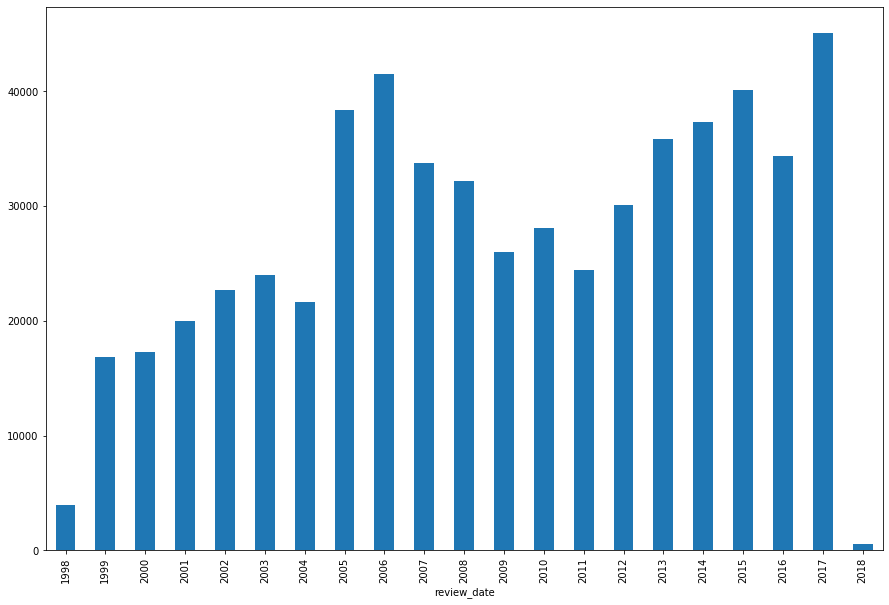

In [18]:
# Distribution of the reviews by year
df_reviews.groupby(df_reviews["review_date"].dt.year)['review_date'].count().plot(kind="bar", figsize = (15, 10))

### Can plot synopsis aids in the detection of spoiler reviews?

In [13]:
# check any movie that has empty plot_synopsis
df_movie[df_movie.plot_synopsis == '']

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
2,tt0243655,"The setting is Camp Firewood, the year 1981. It's the last day before everyo...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
10,tt0107131,"Three pets (Chance, a young dog unfamiliar with the world; Shadow, an aging,...",1h 24min,"[Adventure, Comedy, Drama]",6.9,1993-02-12,
11,tt0110364,"In Urbania, Ohio, snobby ex-football star Kevin O'Shea conducts try-outs for...",1h 47min,"[Comedy, Family, Sport]",6.3,1994-10-14,
22,tt0101700,The story is centered on a microcosm of a post-apocalyptic society where foo...,1h 39min,"[Comedy, Crime]",7.7,1992-04-03,
24,tt0102768,Henry is a lawyer who survives a shooting only to find he cannot remember an...,1h 48min,"[Drama, Romance]",6.7,1991-07-10,
...,...,...,...,...,...,...,...
1556,tt0285531,"Four childhood friends, Jonesy, Beaver, Pete and Henry all share a special s...",2h 14min,"[Drama, Horror, Sci-Fi]",5.5,2003-03-21,
1564,tt0914798,Young Bruno lives a wealthy lifestyle in prewar Germany along with his mothe...,1h 34min,"[Drama, War]",7.8,2008-11-26,
1566,tt4047038,Centers on the titular holistic detective who investigates cases involving t...,1h,"[Comedy, Mystery, Sci-Fi]",8.4,2017-04-01,
1570,tt0104014/,"For a while now, beautiful 24-year-old Diana Bruni who's been happily marrie...",1h 33min,"[Comedy, Drama]",5.3,1992-02-21,


In [14]:
print("No. of movies that do not have plot_synopsis:", len(df_movie[df_movie.plot_synopsis == '']))
print("% of movies that do not have plot_synopsis",  len(df_movie[df_movie.plot_synopsis == ''])/len(df_movie))

No. of movies that do not have plot_synopsis: 233
% of movies that do not have plot_synopsis 0.14821882951653945


In [5]:
# Extract the movie_id that do no plot_synopsis into a list
movie_no_plot_synopsis = df_movie[df_movie.plot_synopsis == '']['movie_id'].tolist()

In [16]:
len(movie_no_plot_synopsis)

233

In [17]:
print("No. of reviews that belong to movies with no plot_synopsis:", len(df_reviews[df_reviews.movie_id.isin(movie_no_plot_synopsis)]))
print("% of reviews that belong to movies with no plot_synopsis:", len(df_reviews[df_reviews.movie_id.isin(movie_no_plot_synopsis)])/len(df_reviews))

No. of reviews that belong to movies with no plot_synopsis: 35078
% of reviews that belong to movies with no plot_synopsis: 0.06112076220611835


In [18]:
print("Out of these reviews, the breakdown of 'is_spoiler'")
print(df_reviews[df_reviews.movie_id.isin(movie_no_plot_synopsis)]['is_spoiler'].value_counts())
print("")
print("In Percentage")
print(df_reviews[df_reviews.movie_id.isin(movie_no_plot_synopsis)]['is_spoiler'].value_counts()/len(df_reviews[df_reviews.movie_id.isin(movie_no_plot_synopsis)]))

Out of these reviews, the breakdown of 'is_spoiler'
False    27263
True      7815
Name: is_spoiler, dtype: int64

In Percentage
False    0.777211
True     0.222789
Name: is_spoiler, dtype: float64


Thoughts: By comparing the similarity of the review_text with the plot_synopsis, we could possibily determine if the review_text is a spoiler or not. Hence, to test this model, we could remove movies with no plot_synopsis and reviews that belong to these movies.

### Genre EDA

In [6]:
#Used the following codes to create a dictionary, showing the movies in each genre.
#Dictionary structure:
#{genre: (count of movies, [movie1, movie2, ..., movie n])
genreDic = {}
for g, m in zip(df_movie['genre'], df_movie['movie_id']):
    for i in g: #Each movie might have multiple genre.
        if i in genreDic:
            genreDic[i][0] += 1
            genreDic[i][1].append(m)
        else:
            genreDic[i] = [1, [m]]

#Convert from dictionary to dataframe.
genreDic = pd.DataFrame.from_dict(genreDic, orient='index', columns=['Count', 'Movie ID'])
genreDic = genreDic.reset_index()
genreDic.rename(columns={'index':'Genre'}, inplace=True)
genreDic.head()

,Genre,Count,Movie ID
0,Action,438,"[tt0105112, tt0286716, tt0090605, tt0121765, tt0143145, tt0343818, tt0253754..."
1,Thriller,233,"[tt0105112, tt0450259, tt0143145, tt0435625, tt0082096, tt3011894, tt0140352..."
2,Comedy,525,"[tt1204975, tt0243655, tt0126886, tt0243155, tt0443453, tt0107131, tt0110364..."
3,Romance,237,"[tt0243655, tt0126886, tt0243155, tt0102768, tt0108399, tt0107822, tt1120985..."
4,Adventure,433,"[tt0040897, tt0090605, tt0121765, tt0107131, tt0450259, tt0143145, tt0435625..."


In [20]:
len(genreDic)

21

# 3 Data Pre-Processing<a id="3"></a>

## 3.1 Data Clean-up<a id="3.1"></a>

There are 2 movie_id that are append with a slash at the end. We have to remove these slashes

In [19]:
display(df_movie[df_movie['movie_id'].apply(lambda x: len(x)) != 9], df_reviews[df_reviews['movie_id'].apply(lambda x: len(x)) != 9])

,duration,genre,movie_id,plot_summary,plot_synopsis,rating,release_date
1570,1h 33min,"[Comedy, Drama]",tt0104014/,"For a while now, beautiful 24-year-old Diana Bruni who's been happily marrie...",,5.3,1992-02-21
1571,1h 32min,"[Drama, Thriller]",tt0114142/,"The marriage of David Burgess, a senior executive, and his beautiful wife, S...",,4.0,1999-01-29


,is_spoiler,movie_id,rating,review_date,review_summary,review_text,user_id


In [7]:
df_movie.at[1570, 'movie_id'] = df_movie.iloc[1570].movie_id[0:9]
df_movie.at[1571, 'movie_id'] = df_movie.iloc[1571].movie_id[0:9]

In [8]:
df_movie.iloc[-2:]

,duration,genre,movie_id,plot_summary,plot_synopsis,rating,release_date
1570,1h 33min,"[Comedy, Drama]",tt0104014,"For a while now, beautiful 24-year-old Diana Bruni who's been happily marrie...",,5.3,1992-02-21
1571,1h 32min,"[Drama, Thriller]",tt0114142,"The marriage of David Burgess, a senior executive, and his beautiful wife, S...",,4.0,1999-01-29


## 3.2 Merge dataframes<a id="3.2"></a>

In [9]:
df_reviews = pd.merge(df_reviews, df_movie, on='movie_id', suffixes=('_review', '_movie'))

In [10]:
df_reviews.sample(5)

,is_spoiler,movie_id,rating_review,review_date,review_summary,review_text,user_id,duration,genre,plot_summary,plot_synopsis,rating_movie,release_date
167824,True,tt1601913,3,2012-04-16,over rated and dumb,reading some of the reviews and forum-post and seeing the high score forced ...,ur4499338,1h 57min,"[Action, Adventure, Drama]","In Alaska, a team of oil workers board a flight home; however, they cross a ...",John Ottway (Liam Neeson) works in Alaska killing the wolves that threaten a...,6.8,2012-01-27
78637,False,tt0050976,10,2002-08-12,Missing the point?,"Some previous comments have said that the knight attempts to cheat Death, bu...",ur1772076,1h 36min,"[Drama, Fantasy]",A Knight and his squire are home from the crusades. Black Death is sweeping ...,"The night had brought little relief from the heat, and at dawn a hot gust of...",8.2,1958-10-13
244259,True,tt1340138,10,2015-07-04,Genisys=Terminator Awesomeness!,Warning: Some spoilers included.I have been endlessly fascinated and captiva...,ur22495283,2h 6min,"[Action, Adventure, Sci-Fi]","When John Connor (Jason Clarke), leader of the human resistance, sends Sgt. ...","In the year 2029, John Connor (Jason Clarke), leader of the human Resistance...",6.5,2015-07-01
82434,False,tt0993846,1,2014-01-01,"Misogynistic, Ableist, Racist, and apologist.",I'm going to come right out and say I did not finish the movie. The fact tha...,ur49433520,3h,"[Biography, Comedy, Crime]",Jordan Belfort is a Long Island penny stockbroker who served 22 months in pr...,"The movie opens with a TV advertisement for Stratton Oakmont, Inc. It discus...",8.2,2013-12-25
331286,False,tt0268126,8,2015-03-07,"Very Bizarre and Risky Film for Everyone Involved,",Adaptation is a fantastic movie with a very well developed plot and an outst...,ur23055365,1h 54min,"[Comedy, Drama]","While his latest movie Being John Malkovich (1999) is in production, screenw...","John Laroche and his wife run a successful Florida nursery, but tragedy stri...",7.7,2003-02-14


In [26]:
df_reviews[df_reviews['plot_synopsis'] == ""]

,review_date,movie_id,user_id,is_spoiler,review_text,rating_review,review_summary,plot_summary,duration,genre,rating_movie,release_date,plot_synopsis
33006,2017-11-28,tt2380307,ur40922393,True,"Well Disney and pixar really make such a great movies this year, kinda class...",10,My Favorite Animation Movie of the year,"Despite his family's baffling generations-old ban on music, Miguel dreams of...",1h 45min,"[Animation, Adventure, Comedy]",8.7,2017-11-21,
33007,2017-12-02,tt2380307,ur82902717,True,"One of the best movie ever, it is an amazing animated movie which once again...",10,Perfect Movie Ever,"Despite his family's baffling generations-old ban on music, Miguel dreams of...",1h 45min,"[Animation, Adventure, Comedy]",8.7,2017-11-21,
33008,2017-11-28,tt2380307,ur77583109,True,It's not a secret that every time Disney's Pixar make people of all ages spe...,8,Disney did it again! A heartwarming and dazzling family movie about the impo...,"Despite his family's baffling generations-old ban on music, Miguel dreams of...",1h 45min,"[Animation, Adventure, Comedy]",8.7,2017-11-21,
33009,2017-11-22,tt2380307,ur24925987,True,"I did not watch this in 3D.Before I begin with ""CoCo"", I would like to state...",5,"Sorry, but mostly a Snoozefest.","Despite his family's baffling generations-old ban on music, Miguel dreams of...",1h 45min,"[Animation, Adventure, Comedy]",8.7,2017-11-21,
33010,2017-10-30,tt2380307,ur81543020,True,"Taking place in contemporary Mexico, in a fictional village named Santa Ceci...",10,A beautiful story and a faithful depiction of Mexican culture,"Despite his family's baffling generations-old ban on music, Miguel dreams of...",1h 45min,"[Animation, Adventure, Comedy]",8.7,2017-11-21,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
573094,2001-01-13,tt0157503,ur0333576,False,"Drop Dead Gorgeous is an unfortunate entry into the ""mockumentary"" category ...",3,a misguided attempt at comedy,"In a small Minnesota town, the annual beauty pageant is being covered by a T...",1h 37min,"[Comedy, Romance, Thriller]",6.6,1999-07-23,
573095,2000-12-19,tt0157503,ur0388177,False,"There is not one surprise in this movie, it is one of the worst movies i hav...",1,This movie sucks bigtime...,"In a small Minnesota town, the annual beauty pageant is being covered by a T...",1h 37min,"[Comedy, Romance, Thriller]",6.6,1999-07-23,
573096,1999-07-24,tt0157503,ur0285685,False,Well where do I begin ? I must say before any comment I may have that this m...,4,It had its' moments....,"In a small Minnesota town, the annual beauty pageant is being covered by a T...",1h 37min,"[Comedy, Romance, Thriller]",6.6,1999-07-23,
573097,1999-07-24,tt0157503,ur0384453,False,Denise Richards is hilarious as a ruthless teen beauty queen who resorts to ...,5,Uneven,"In a small Minnesota town, the annual beauty pageant is being covered by a T...",1h 37min,"[Comedy, Romance, Thriller]",6.6,1999-07-23,


## 3.3 Remove reviews and movies that do not have plot synopsis<a id="3.3"></a>

In [11]:
df_reviews = df_reviews[df_reviews['plot_synopsis'] != ""]

In [12]:
df_movie = df_movie[df_movie['plot_synopsis'] != ""]

In [13]:
# Check the number of data
print('No. of reviews:', len(df_reviews))
print('No. of movie:', len(df_movie))

No. of reviews: 538828
No. of movie: 1339


In [30]:
# is_Spoiler - breakdown
print("No. of spoilers: {} ({:.2f}%)".format(len(df_reviews[df_reviews.is_spoiler==True]),100*len(df_reviews[df_reviews.is_spoiler==True])/len(df_reviews)))
print("No. of non-spoilers: {} ({:.2f}%)".format(len(df_reviews[df_reviews.is_spoiler==False]),100*len(df_reviews[df_reviews.is_spoiler==False])/len(df_reviews)))

No. of spoilers: 143109 (26.56%)
No. of non-spoilers: 395719 (73.44%)


In [14]:
# Reset the index of both the df_reviews and df_movie
df_reviews.reset_index(drop=True, inplace=True)
df_movie.reset_index(drop=True, inplace=True)

# 4 Feature Engineering<a id="4"></a>

## 4.1 Review Word Count<a id="4.1"></a>

In [15]:
# Create new column that stores the word counts of review
df_reviews['review_wc'] = df_reviews['review_text'].apply(lambda x: len(str(x).split()))

In [33]:
df_reviews['review_wc'].describe()

count    538828.000000
mean        260.823278
std         196.197209
min           1.000000
25%         132.000000
50%         190.000000
75%         324.000000
max        2675.000000
Name: review_wc, dtype: float64

In [34]:
df_reviews[df_reviews.is_spoiler == True]['review_wc'].describe()

count    143109.000000
mean        335.857353
std         223.562551
min           5.000000
25%         167.000000
50%         262.000000
75%         437.000000
max        2562.000000
Name: review_wc, dtype: float64

In [35]:
df_reviews[df_reviews.is_spoiler == False]['review_wc'].describe()

count    395719.000000
mean        233.687730
std         177.670705
min           1.000000
25%         124.000000
50%         172.000000
75%         282.000000
max        2675.000000
Name: review_wc, dtype: float64

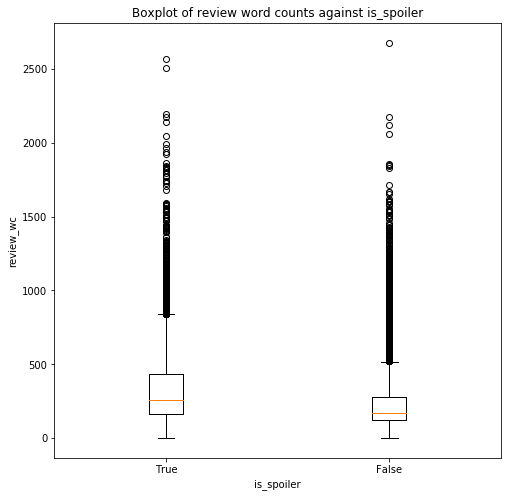

In [36]:
# Plot the boxplot of the word counts 
data = [df_reviews[df_reviews.is_spoiler == True]['review_wc'], df_reviews[df_reviews.is_spoiler == False]['review_wc']]
plt.figure(figsize = (8,8))
plt.boxplot(data, showfliers=True)
plt.title('Boxplot of review word counts against is_spoiler')
plt.xticks(range(1,3), ['True', 'False'])
plt.xlabel('is_spoiler')
plt.ylabel('review_wc')
plt.show()

Remarks: In general, spoiler contents tend to have higher word counts.

## 4.2 Review Rating<a id="4.2"></a>

In [37]:
df_reviews[df_reviews.is_spoiler == True]['rating_review'].describe()

count    143109.000000
mean          6.518717
std           3.018999
min           1.000000
25%           4.000000
50%           7.000000
75%           9.000000
max          10.000000
Name: rating_review, dtype: float64

In [38]:
df_reviews[df_reviews.is_spoiler == False]['rating_review'].describe()

count    395719.000000
mean          7.122185
std           2.919836
min           1.000000
25%           5.000000
50%           8.000000
75%          10.000000
max          10.000000
Name: rating_review, dtype: float64

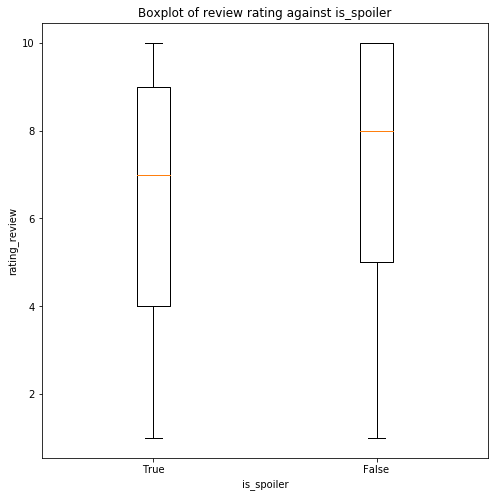

In [39]:
# Plot the boxplot of the ratings 
data = [df_reviews[df_reviews.is_spoiler == True]['rating_review'], df_reviews[df_reviews.is_spoiler == False]['rating_review']]
plt.figure(figsize = (8,8))
plt.boxplot(data, showfliers=True)
plt.title('Boxplot of review rating against is_spoiler')
plt.xticks(range(1,3), ['True', 'False'])
plt.xlabel('is_spoiler')
plt.ylabel('rating_review')
plt.show()

Remarks: In general, spoiler contents tend to have lower ratings.

## 4.3 Genre<a id="4.3"></a>

In [16]:
# Binarize the Genre for each reviews
s = df_reviews['genre']

mlb = preprocessing.MultiLabelBinarizer()

genre_dummy= pd.DataFrame(mlb.fit_transform(s),columns='genre_'+mlb.classes_)

In [17]:
genre_dummy.sample(5)

,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Film-Noir,...,genre_Horror,genre_Music,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western
364891,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502262,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
17638,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
171434,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26163,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [18]:
df_reviews = pd.concat([df_reviews, genre_dummy], axis = 1)

In [43]:
df_reviews.filter(regex='genre').sample(10)

,genre,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,...,genre_Horror,genre_Music,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western
530661,"[Action, Adventure, Comedy]",1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
461692,"[Adventure, Comedy, Sci-Fi]",0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
27025,"[Adventure, Drama]",0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
249983,"[Action, Adventure, Sci-Fi]",1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
494969,"[Horror, Mystery]",0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
192779,"[Action, Adventure, Sci-Fi]",1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
70736,"[Comedy, Romance]",0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
506451,"[Action, Crime, Sci-Fi]",1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
326170,"[Adventure, Comedy, Family]",0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
148825,"[Action, Adventure, Sci-Fi]",1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## 4.4 Bag of Words<a id="4.4"></a>

<b> Define a tokenizer function that does the following:
    <li> Convert to text to lower case </li>
    <li> Remove punctuations and special characters </li>
    <li> Extract words that are at least 2 characters </li>
    <li> Remove stop words </li>
    <li> Perform lemmatization of the words </li>

In [19]:
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english')) 

lemmatizer = WordNetLemmatizer()

# lemmatizer_tokenizer will remove stopwords and lemmatize the words
def lemmatizer_tokenizer(str_input):
    words = re.compile(r"\b[A-Za-z]{2,}\b").findall(str_input.lower())
    words = [lemmatizer.lemmatize(word) for word in words if not word in stop_words]
    return words

In [20]:
# count_vectorizer = feature_extraction.text.CountVectorizer(min_df = 0.001, tokenizer = lemmatizer_tokenizer)
count_vectorizer = feature_extraction.text.CountVectorizer(tokenizer = lemmatizer_tokenizer)

# Train the count_vectorizer using all the (1) review_text from df_reviews and (2) plot_synopsis from df_movie
X_BOW = count_vectorizer.fit_transform(pd.concat([df_reviews['review_text'], df_movie['plot_synopsis']]))

vocab_BOW = count_vectorizer.get_feature_names()

#Number of features/words extracted
print('Number of features/words extracted for BOW:', len(vocab_BOW))

Number of features/words extracted for BOW: 245539


In [46]:
# Obtain the count matrix for the reviews and the plot_synopsis respectively by splitting the X_BOW
X_BOW_reviews = X_BOW[:len(df_reviews)] 
X_BOW_movie = X_BOW[len(df_reviews):] 

In [47]:
X_BOW_reviews.shape, X_BOW_movie.shape

((538828, 245539), (1339, 245539))

## 4.5 TF-IDF<a id="4.5"></a>

In [48]:
# tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(min_df = 0.001, tokenizer = lemmatizer_tokenizer)
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(tokenizer = lemmatizer_tokenizer)

# Train the tfidf_vectorizer using all the (1) review_text from df_reviews and (2) plot_synopsis from df_movie
X_TFIDF = tfidf_vectorizer.fit_transform(pd.concat([df_reviews['review_text'], df_movie['plot_synopsis']]))

vocab_TFIDF = tfidf_vectorizer.get_feature_names()

#Number of features/words extracted
print('Number of features/words extracted for TF-IDF:', len(vocab_TFIDF))

Number of features/words extracted for TF-IDF: 245539


In [49]:
# Obtain the TF-IDF matrix for the reviews and the plot_synopsis respectively by splitting the X_TFIDF
X_TFIDF_reviews = X_TFIDF[:len(df_reviews)] 
X_TFIDF_movie = X_TFIDF[len(df_reviews):]

In [50]:
X_TFIDF_reviews.shape, X_TFIDF_movie.shape

((538828, 245539), (1339, 245539))

## 4.6 Latent Semantic Analysis (LSA)<a id="4.6"></a>

### Using BOW to build the tSVD

In [56]:
# Build a truncated SVD using the BOW matrix
k = 50
tSVD_BOW = decomposition.TruncatedSVD(n_components = k, random_state = 2020)
X_BOW_tSVD = tSVD_BOW.fit_transform(X_BOW)

In [57]:
# Obtain the matrix for the reviews and the plot_synopsis respectively by splitting the X_BOW_tSVD
X_BOW_tSVD_reviews = X_BOW_tSVD[:len(df_reviews)] 
X_BOW_tSVD_movie = X_BOW_tSVD[len(df_reviews):] 

In [58]:
percent_variance_BOW = np.round(tSVD_BOW.explained_variance_ratio_* 100, decimals =3)
percent_variance_BOW

array([6.054, 4.94 , 1.68 , 0.821, 0.723, 0.634, 0.575, 0.565, 0.487,
       0.469, 0.461, 0.433, 0.42 , 0.399, 0.375, 0.363, 0.352, 0.335,
       0.332, 0.327, 0.321, 0.314, 0.309, 0.3  , 0.293, 0.287, 0.286,
       0.275, 0.265, 0.264, 0.26 , 0.244, 0.234, 0.23 , 0.227, 0.221,
       0.214, 0.212, 0.209, 0.205, 0.202, 0.199, 0.195, 0.19 , 0.188,
       0.186, 0.184, 0.181, 0.178, 0.174])

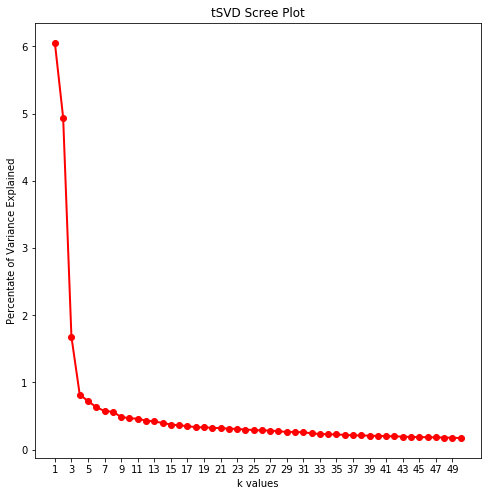

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,8))
plt.plot(range(1,51), percent_variance_BOW, 'ro-', linewidth=2)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('k values')
plt.title('tSVD Scree Plot')
plt.xticks(range(1,51,2))
plt.show()

### Using TF-IDF to build the tSVD

In [55]:
# Build a truncated SVD using the TFIDF matrix
k = 50
tSVD_TFIDF = decomposition.TruncatedSVD(n_components = k, random_state = 2020)
X_TFIDF_tSVD = tSVD_TFIDF.fit_transform(X_TFIDF)

In [56]:
# Obtain the matrix for the reviews and the plot_synopsis respectively by splitting the X_BOW_tSVD
X_TFIDF_tSVD_reviews = X_TFIDF_tSVD[:len(df_reviews)] 
X_TFIDF_tSVD_movie = X_TFIDF_tSVD[len(df_reviews):] 

In [57]:
percent_variance_TFIDF = np.round(tSVD_TFIDF.explained_variance_ratio_* 100, decimals =3)
percent_variance_TFIDF

array([0.369, 0.605, 0.272, 0.245, 0.241, 0.232, 0.205, 0.2  , 0.184,
       0.168, 0.161, 0.159, 0.153, 0.148, 0.141, 0.135, 0.135, 0.13 ,
       0.127, 0.126, 0.125, 0.118, 0.117, 0.117, 0.115, 0.112, 0.108,
       0.107, 0.105, 0.104, 0.101, 0.1  , 0.097, 0.096, 0.095, 0.094,
       0.092, 0.091, 0.091, 0.089, 0.088, 0.087, 0.086, 0.085, 0.084,
       0.082, 0.082, 0.081, 0.08 , 0.079])

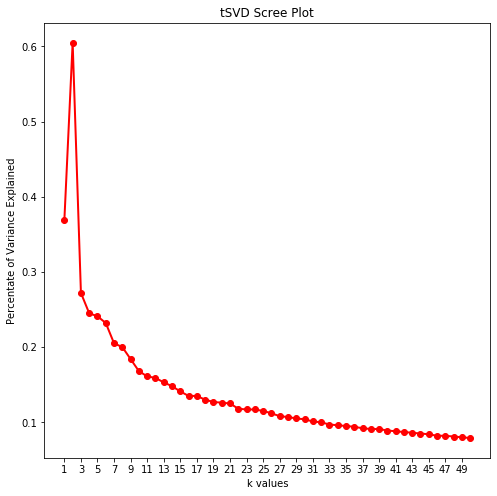

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,8))
plt.plot(range(1,51), percent_variance_TFIDF, 'ro-', linewidth=2)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('k values')
plt.title('tSVD Scree Plot')
plt.xticks(range(1,51,2))
plt.show()

In [59]:
tSVD_TFIDF.components_.shape

(50, 245539)

### Calculate the cosine similarity between the review_text and the plot_synopsis

In [60]:
def cos_sim (a, b):
    if np.dot(a,b) == 0.0:
        return 0.0
    else:
        return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

In [61]:
sim_BOW = []
for i in range(len(df_reviews)):
    movie_id = df_reviews.loc[i].movie_id
    movie_index = df_movie[df_movie.movie_id == df_reviews.loc[i].movie_id].index.values[0]
    sim_score = cos_sim(X_BOW_tSVD_reviews[i], X_BOW_tSVD_movie[movie_index])
    sim_BOW.append(sim_score)   

In [62]:
sim_TFIDF = []
for i in range(len(df_reviews)):
    movie_id = df_reviews.loc[i].movie_id
    movie_index = df_movie[df_movie.movie_id == df_reviews.loc[i].movie_id].index.values[0]
    sim_score = cos_sim(X_TFIDF_tSVD_reviews[i], X_TFIDF_tSVD_movie[movie_index])
    sim_TFIDF.append(sim_score)

In [63]:
df_reviews['sim_BOW'] = sim_BOW

In [64]:
df_reviews['sim_TFIDF'] = sim_TFIDF

In [65]:
df_reviews[['is_spoiler', 'sim_BOW', 'sim_TFIDF']].sample(10)

,is_spoiler,sim_BOW,sim_TFIDF
63044,False,0.242598,0.634497
57466,False,0.490307,0.502658
4879,False,0.269955,0.421556
299654,True,0.308559,0.472620
279965,False,0.146539,0.275984
192215,True,0.649760,0.803499
87432,True,0.290143,0.587001
289599,False,0.443879,0.784821
157838,False,0.446850,0.794150
6803,False,0.588291,0.808327


## 4.7 Latent Dirichlet Allocation (LDA)<a id="4.7"></a> - <font color="red"> I think should remove this as a feature, it is taking a long long long time to train. Thus far, I have not managed to train finish. </font>

### Using BOW to build the LDA

In [ ]:
# Instead of using the whole feature space, we remove low occurrences words.
# This is fasten the speed of training the LDA model.
count_vectorizer2 = feature_extraction.text.CountVectorizer(min_df = 0.005, tokenizer = lemmatizer_tokenizer)

# Train the count_vectorizer using all the (1) review_text from df_reviews and (2) plot_synopsis from df_movie
X_BOW2 = count_vectorizer2.fit_transform(pd.concat([df_reviews['review_text'], df_movie['plot_synopsis']]))

vocab_BOW2 = count_vectorizer2.get_feature_names()

#Number of features/words extracted
print('Number of features/words extracted for BOW:', len(vocab_BOW2))

In [ ]:
# Build a LDA model using the BOW matrix
k = 15
lda_BOW = decomposition.LatentDirichletAllocation(n_components = k, random_state = 2020)
X_BOW_LDA = lda_BOW.fit_transform(X_BOW2)

In [ ]:
# Obtain the matrix for the reviews and the plot_synopsis respectively by splitting the X_BOW_LDA
X_BOW_LDA_reviews = X_BOW_LDA[:len(df_reviews)] 
X_BOW_LDA_movie = X_BOW_LDA[len(df_reviews):] 

### Using TF-IDF to build the LDA

In [ ]:
# Instead of using the whole feature space, we remove low occurrences words.
# This is fasten the speed of training the LDA model.
tfidf_vectorizer2 = feature_extraction.text.TfidfVectorizer(min_df = 0.005, tokenizer = lemmatizer_tokenizer)

# Train the tfidf_vectorizer using all the (1) review_text from df_reviews and (2) plot_synopsis from df_movie
X_TFIDF2 = tfidf_vectorizer2.fit_transform(pd.concat([df_reviews['review_text'], df_movie['plot_synopsis']]))

vocab_TFIDF2 = tfidf_vectorizer2.get_feature_names()

#Number of features/words extracted
print('Number of features/words extracted for TF-IDF:', len(vocab_TFIDF2))

In [ ]:
# Build a LDA model using the TFIDF matrix
k = 15
lda_TFIDF = decomposition.LatentDirichletAllocation(n_components = k, random_state = 2020)
X_TFIDF_LDA = lda_TFIDF.fit_transform(X_TFIDF2)

In [ ]:
# Obtain the matrix for the reviews and the plot_synopsis respectively by splitting the X_TFIDF_LDA
X_TFIDF_LDA_reviews = X_TFIDF_LDA[:len(df_reviews)] 
X_TFIDF_LDA_movie = X_TFIDF_LDA[len(df_reviews):] 

## 4.8 Doc2Vec<a id="4.8"></a>

In [64]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn import utils

In [66]:
# Convert all the review_text to tokens and add a tag that is prefix with 'review_'
review_tagged = [TaggedDocument(words=lemmatizer_tokenizer(_d), tags=['review_'+str(i)]) for i, _d in enumerate(df_reviews['review_text'])]
len(review_tagged)

5

In [68]:
# Convert all the movie's plot_synopsis to tokens and add a tag that is prefix with 'movie_'
movie_plot_tagged = [TaggedDocument(words=lemmatizer_tokenizer(_d), tags=['movie_'+str(i)]) for i, _d in enumerate(df_movie['plot_synopsis'])]
len(movie_plot_tagged)

1339

In [69]:
# add both the review texts and movie's plot synopsis into a single tagged_data that will be used to train the Doc2Vec models.
tagged_data = review_tagged+movie_plot_tagged
len(tagged_data)

540167

### Doc2Vec using Distributed Bag of Words (DBOW)

In [70]:
import multiprocessing
cores = multiprocessing.cpu_count()

d2v_dbow = Doc2Vec(dm=0, vector_size=50, negative=5, 
                  hs=0, min_count=2, sample = 0, workers=cores,
                  alpha=0.025, min_alpha=0.001)

d2v_dbow.build_vocab([x for x in tqdm(tagged_data)])

100%|██████████| 540167/540167 [00:00<00:00, 3385070.96it/s]


In [ ]:
%%time
for epoch in range(50):
    d2v_dbow.train(utils.shuffle([x for x in tqdm(tagged_data)]), total_examples=len(tagged_data), epochs=1)
    d2v_dbow.alpha -= 0.002
    d2v_dbow.min_alpha = d2v_dbow.alpha

    
d2v_dbow.save("d2v_dbow.model")
print("Model Saved")

In [129]:
# Clear memory after training
d2v_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [71]:
#Load the model - skip the training
d2v_dbow = Doc2Vec.load("d2v_dbow.model")

In [72]:
def get_vectors(model, corpus, dim, prefix):
    vecs = np.zeros((len(corpus), dim))
    n = 0
    for i in corpus.index:
        vecs[n] = model.docvecs[prefix+str(i)]
        n += 1
    return vecs

In [73]:
X_d2vDBOW_reviews = get_vectors(d2v_dbow, df_reviews['review_text'], 50, 'review_')
X_d2vDBOW_movie = get_vectors(d2v_dbow, df_movie['plot_synopsis'], 50, 'movie_')
X_d2vDBOW_reviews.shape, X_d2vDBOW_movie.shape

((538828, 50), (1339, 50))

In [74]:
# Create consine simliarity of the review against the movie's plot synopsis using d2v_DBOW vectors
sim_d2vDBOW = []
for i in range(len(df_reviews)):
    movie_id = df_reviews.loc[i].movie_id
    movie_index = df_movie[df_movie.movie_id == df_reviews.loc[i].movie_id].index.values[0]
    sim_score = cos_sim(X_d2vDBOW_reviews[i], X_d2vDBOW_movie[movie_index])
    sim_d2vDBOW.append(sim_score)

In [81]:
df_reviews['sim_d2vDBOW'] = sim_d2vDBOW

### Doc2Vec using Distributed Memory Mean (DMM)

In [75]:
d2v_dmm = Doc2Vec(dm=1, dm_mean=1, window = 5, vector_size=50, negative=5, 
                  hs=0, min_count=2, sample = 0, workers=cores,
                  alpha=0.025, min_alpha=0.001)

d2v_dmm.build_vocab([x for x in tqdm(tagged_data)])

100%|██████████| 540167/540167 [00:00<00:00, 2314594.48it/s]


In [ ]:
%%time
# Can skip this --- Just load the model below.
for epoch in range(50):
    d2v_dmm.train(utils.shuffle([x for x in tqdm(tagged_data)]), total_examples=len(tagged_data), epochs=1)
    d2v_dmm.alpha -= 0.002
    d2v_dmm.min_alpha = d2v_dmm.alpha

    
d2v_dmm.save("d2v_dmm.model")
print("Model Saved")

In [130]:
# Clear memory after training
d2v_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [76]:
#Load the model - skip the training
d2v_dmm = Doc2Vec.load("d2v_dmm.model")

In [77]:
X_d2vDMM_reviews = get_vectors(d2v_dmm, df_reviews['review_text'], 50, 'review_')
X_d2vDMM_movie = get_vectors(d2v_dmm, df_movie['plot_synopsis'], 50, 'movie_')
X_d2vDMM_reviews.shape, X_d2vDMM_movie.shape

((538828, 50), (1339, 50))

In [78]:
# Create consine simliarity of the review against the movie's plot synopsis using d2v_DBOW vectors
sim_d2vDMM = []
for i in range(len(df_reviews)):
    movie_id = df_reviews.loc[i].movie_id
    movie_index = df_movie[df_movie.movie_id == df_reviews.loc[i].movie_id].index.values[0]
    sim_score = cos_sim(X_d2vDMM_reviews[i], X_d2vDMM_movie[movie_index])
    sim_d2vDMM.append(sim_score)

In [79]:
df_reviews['sim_d2vDMM'] = sim_d2vDMM

In [82]:
df_reviews[['is_spoiler', 'sim_BOW', 'sim_TFIDF', 'sim_d2vDBOW', 'sim_d2vDMM']].sample(10)

,is_spoiler,sim_BOW,sim_TFIDF,sim_d2vDBOW,sim_d2vDMM
178845,False,0.178950,0.330043,0.624122,0.220366
492219,False,0.159255,0.373846,0.684254,0.135205
407274,True,0.393851,0.524109,0.643233,0.245301
482326,False,0.336964,0.562532,0.798032,0.314402
365035,False,0.079539,0.288449,0.444606,-0.084549
120006,False,0.155645,0.387545,0.700194,-0.246014
207306,False,0.387911,0.438247,0.693420,-0.024894
529582,False,0.168290,0.220660,0.658925,-0.422321
302794,False,0.287843,0.577154,0.707993,0.655182
151116,False,0.225631,0.303184,0.438299,0.527700


## 4.9 Output Features to csv<a id="4.9"></a>

a) review_wc, rating_review, genre, sim_BOW, sim_TFIDF, sim_d2vDBOW, sim_d2vDMM

In [152]:
output_df = pd.concat([df_reviews[['review_wc', 'rating_review', 'sim_BOW', 'sim_TFIDF', 'sim_d2vDBOW', 'sim_d2vDMM']], 
                       df_reviews.filter(regex='genre_')], axis = 1)
output_df.shape

(538828, 27)

In [153]:
output_df.to_csv(r'X_for-df_reviews.csv')

b) The 4 x 50-dimension vectors

In [156]:
np.savetxt("X_BOW_tSVD_reviews.csv", X_BOW_tSVD_reviews, delimiter=",")

In [157]:
np.savetxt("X_TFIDF_tSVD_reviews.csv", X_TFIDF_tSVD_reviews, delimiter=",")

In [158]:
np.savetxt("X_d2vDBOW_reviews.csv", X_d2vDBOW_reviews, delimiter=",")

In [159]:
np.savetxt("X_d2vDMM_reviews.csv", X_d2vDMM_reviews, delimiter=",")

## 4.10 Extract features from csv<a id="4.9"></a>

In [35]:
input_df = pd.read_csv(r'X_for-df_reviews.csv', index_col = 0)

In [36]:
input_df

,review_wc,rating_review,sim_BOW,sim_TFIDF,sim_d2vDBOW,sim_d2vDMM,genre_Action,genre_Adventure,genre_Animation,genre_Biography,...,genre_Horror,genre_Music,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,genre_War,genre_Western
0,843,10,0.514819,0.747133,0.849186,0.765384,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,223,10,0.380263,0.721895,0.717703,0.128926,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,250,8,0.380265,0.755286,0.694464,0.193391,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,741,10,0.409849,0.541186,0.806651,0.423644,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,829,8,0.502294,0.763715,0.871868,0.519318,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538823,52,10,0.368513,0.416531,0.775979,0.098757,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
538824,54,9,0.205377,0.259288,0.619341,-0.211641,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
538825,202,10,0.323489,0.279125,0.563845,0.031844,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
538826,89,3,0.196956,0.174277,0.550819,-0.227841,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df_reviews

,review_date,movie_id,user_id,is_spoiler,review_text,rating_review,review_summary,plot_summary,duration,genre,rating_movie,release_date,plot_synopsis
0,2006-02-10,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (written and directed by Frank Darab...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly successful banker as a prisoner in ...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker in Maine, is convicted of mur..."
1,2000-09-06,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt one of the most brilliant movies...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly successful banker as a prisoner in ...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker in Maine, is convicted of mur..."
2,2001-08-03,tt0111161,ur1285640,True,"I believe that this film is the best story ever told on film, and I'm about ...",8,The best story ever told on film,Chronicles the experiences of a formerly successful banker as a prisoner in ...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker in Maine, is convicted of mur..."
3,2002-09-01,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has had such an emotional impact o...",10,Busy dying or busy living?,Chronicles the experiences of a formerly successful banker as a prisoner in ...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker in Maine, is convicted of mur..."
4,2004-05-20,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a brilliant and indelible perfor...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly successful banker as a prisoner in ...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker in Maine, is convicted of mur..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
538823,1999-08-08,tt0139239,ur0100166,False,"Go is wise, fast and pure entertainment. Assembling an exceptional casting i...",10,The best teen movie of the nineties,"Told from three perspectives, a story of a bunch of young Californians tryin...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, the story being told from four..."
538824,1999-07-31,tt0139239,ur0021767,False,"Well, what shall I say. this one´s fun at any rate. Three plotlines, origini...",9,Go - see the movie,"Told from three perspectives, a story of a bunch of young Californians tryin...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, the story being told from four..."
538825,1999-07-20,tt0139239,ur0392750,False,"Go is the best movie I have ever seen, and I've seen a lot of movies. I read...",10,It's the best movie I've ever seen,"Told from three perspectives, a story of a bunch of young Californians tryin...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, the story being told from four..."
538826,1999-06-11,tt0139239,ur0349105,False,Call this 1999 teenage version of Pulp Fiction whatever you want but please ...,3,Haven't we seen this before?,"Told from three perspectives, a story of a bunch of young Californians tryin...",1h 42min,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, the story being told from four..."


In [42]:
df_reviews = pd.concat([df_reviews, input_df], axis = 1)

In [44]:
df_reviews.shape

(538828, 40)

In [45]:
X_BOW_tSVD_reviews = np.loadtxt("X_BOW_tSVD_reviews.csv", delimiter=",")

In [47]:
X_TFIDF_tSVD_reviews = np.loadtxt("X_TFIDF_tSVD_reviews.csv", delimiter=",")

In [48]:
X_d2vDBOW_reviews = np.loadtxt("X_d2vDBOW_reviews.csv", delimiter=",")

In [49]:
X_d2vDMM_reviews = np.loadtxt("X_d2vDMM_reviews.csv", delimiter=",")

# 5 Analysis<a id="5"></a>

<h3> List of Features </h3>
There are a couple of features that we can use:
<li>df_reviews['sim_BOW'] - Cosine Similarity of the review against the movie plot_synopsis using BOW as the Vectorizer </li>
<li>df_reviews['sim_TFIDF'] - Cosine Similarity of the review against the movie plot_synopsis using TFIDF as the Vectorizer </li>
<li> df_reviews['review_wc'] - Word Count of the review</li>
<li> df_reviews['rating_review'] - Rating of the review</li>
<li> df_reviews.filter(regex='genre_') - the one-hot encoding of the movie genre </li>
<li> X_BOW_tSVD_reviews - document embedding of dimension 50 build from truncated SVD using BOW as the Vectorizer </li>
<li> X_TFIDF_tSVD_reviews - document embedding of dimension 50 build from truncated SVD using TFIDF as the Vectorizer </li>

<b> <font color="blue">New features in v0.4
    <li>X_d2vDBOW_reviews - Doc2Vec embedding of dimension 50 on the reviews using DBOW</li>
    <li>X_d2vDMM_reviews - Doc2Vec embedding of dimension 50 on the reviews using DMM</li>
    <li>df_reviews['sim_d2vDBOW'] - Cosine Similarity of the review against the movie plot_synopsis using DBOW </li>
    <li>df_reviews['sim_d2vDMM'] - Cosine Similarity of the review against the movie plot_synopsis using DMM </li>
    </font>

<b> <font color="red">Do choose the features accordingly!!!</font></b>

<h3> Random Oversampling </h3>
<font color="blue"> I realise that our is_spoiler = True data are only about 20%. So, I tried the oversampling technique and it improves the F1-score for the True label. </font>

## 5.1 Performance of different Features using Logistic Regression

In [53]:
# Create empty lists to store all the results
test_id = []
classifier = []
feature = [] 
oversampling_method = []
accuracy_score = []
confusion_matrix = []
classification_report = []
classification_report2 = []
f1_score_of_True = []
f1_precision_recall_fscore_support_of_True = []

In [54]:
# Define basic feature_list
basic_feature_list = [('word_count', df_reviews[['review_wc']].values),
                      ('rating', df_reviews[['rating_review']].values),
                      ('genre', df_reviews.filter(regex='genre_').values)]

In [55]:
classifier_list = [('Logistic Regression', linear_model.LogisticRegression(solver = 'lbfgs', C = 0.001, max_iter = 1000))]

In [56]:
oversampling_list = [('None', ''),
                     ('Random Oversampling', RandomOverSampler(random_state=2020))]

# ('SMOTE', SMOTE(random_state=2020))

In [57]:
%%time

t_id = 1

import itertools

for clf_name, clf in classifier_list:
    
    for L in range(1, len(basic_feature_list)+1):
        for combi in itertools.combinations(basic_feature_list, L):
            f_n = []
            f_v = []
            
            for feature_name, feature_value in combi:
                f_n.append(feature_name)
                f_v.append(feature_value)
            
            x = np.hstack((f_v))
            y = df_reviews['is_spoiler'].values
            x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2,
                                                                                random_state = 2020, stratify = y)
            
            for method_name, method in oversampling_list:
                test_id.append(t_id)
                classifier.append(clf_name)
                feature.append(f_n)
                oversampling_method.append(method_name)
                if method == '':
                    clf.fit(x_train, y_train)
                else:
                    x_train_new, y_train_new = method.fit_sample(x_train, y_train)
                    clf.fit(x_train_new, y_train_new)

                y_test_pred = clf.predict(x_test)
                accuracy_score.append(metrics.accuracy_score(y_test, y_test_pred))
                confusion_matrix.append(metrics.confusion_matrix(y_test, y_test_pred))
                classification_report.append(metrics.classification_report(y_test, y_test_pred, output_dict=True))
                classification_report2.append(metrics.classification_report(y_test, y_test_pred))
                f1_score_of_True.append(metrics.f1_score(y_test, y_test_pred))
                f1_precision_recall_fscore_support_of_True.append(metrics.precision_recall_fscore_support(y_test, y_test_pred, average='binary'))
                print('classifier:', clf_name)
                print('features:', f_n)
                print('oversampling:', method_name)
                print('accuracy:', metrics.accuracy_score(y_test, y_test_pred))
                print('confusion matrix:\n', metrics.confusion_matrix(y_test, y_test_pred))
                print('classification report:\n', metrics.classification_report(y_test, y_test_pred))
                print("")

classifier: Logistic Regression
features: ['word_count']
oversampling: None
accuracy: 0.7335523263366924
confusion matrix:
 [[76401  2743]
 [25971  2651]]
classification report:
               precision    recall  f1-score   support

       False       0.75      0.97      0.84     79144
        True       0.49      0.09      0.16     28622

    accuracy                           0.73    107766
   macro avg       0.62      0.53      0.50    107766
weighted avg       0.68      0.73      0.66    107766


classifier: Logistic Regression
features: ['word_count']
oversampling: Random Oversampling
accuracy: 0.6704990442254515
confusion matrix:
 [[58868 20276]
 [15233 13389]]
classification report:
               precision    recall  f1-score   support

       False       0.79      0.74      0.77     79144
        True       0.40      0.47      0.43     28622

    accuracy                           0.67    107766
   macro avg       0.60      0.61      0.60    107766
weighted avg       0.69    

C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classifier: Logistic Regression
features: ['rating']
oversampling: None
accuracy: 0.7344060278752111
confusion matrix:
 [[79144     0]
 [28622     0]]
classification report:
               precision    recall  f1-score   support

       False       0.73      1.00      0.85     79144
        True       0.00      0.00      0.00     28622

    accuracy                           0.73    107766
   macro avg       0.37      0.50      0.42    107766
weighted avg       0.54      0.73      0.62    107766


classifier: Logistic Regression
features: ['rating']
oversampling: Random Oversampling
accuracy: 0.6065085462947497
confusion matrix:
 [[53505 25639]
 [16766 11856]]
classification report:
               precision    recall  f1-score   support

       False       0.76      0.68      0.72     79144
        True       0.32      0.41      0.36     28622

    accuracy                           0.61    107766
   macro avg       0.54      0.55      0.54    107766
weighted avg       0.64      0.61  

C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classifier: Logistic Regression
features: ['genre']
oversampling: None
accuracy: 0.7344060278752111
confusion matrix:
 [[79144     0]
 [28622     0]]
classification report:
               precision    recall  f1-score   support

       False       0.73      1.00      0.85     79144
        True       0.00      0.00      0.00     28622

    accuracy                           0.73    107766
   macro avg       0.37      0.50      0.42    107766
weighted avg       0.54      0.73      0.62    107766


classifier: Logistic Regression
features: ['genre']
oversampling: Random Oversampling
accuracy: 0.5508973145518995
confusion matrix:
 [[44853 34291]
 [14107 14515]]
classification report:
               precision    recall  f1-score   support

       False       0.76      0.57      0.65     79144
        True       0.30      0.51      0.37     28622

    accuracy                           0.55    107766
   macro avg       0.53      0.54      0.51    107766
weighted avg       0.64      0.55    

C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classifier: Logistic Regression
features: ['rating', 'genre']
oversampling: None
accuracy: 0.7344060278752111
confusion matrix:
 [[79144     0]
 [28622     0]]
classification report:
               precision    recall  f1-score   support

       False       0.73      1.00      0.85     79144
        True       0.00      0.00      0.00     28622

    accuracy                           0.73    107766
   macro avg       0.37      0.50      0.42    107766
weighted avg       0.54      0.73      0.62    107766


classifier: Logistic Regression
features: ['rating', 'genre']
oversampling: Random Oversampling
accuracy: 0.5617356123452666
confusion matrix:
 [[45559 33585]
 [13645 14977]]
classification report:
               precision    recall  f1-score   support

       False       0.77      0.58      0.66     79144
        True       0.31      0.52      0.39     28622

    accuracy                           0.56    107766
   macro avg       0.54      0.55      0.52    107766
weighted avg     

In [58]:
def update_df_result(test_id, feature, classifier, oversampling_method, accuracy_score, 
                     f1_precision_recall_fscore_support_of_True, confusion_matrix, classification_report2):
    
    df = pd.DataFrame()
    df['test_id'] = test_id
    df['feature'] = feature
    df['classifier'] = classifier
    df['oversampling'] = oversampling_method
    df['accuracy'] = accuracy_score
    df['true_precision'] = [i[0] for i in f1_precision_recall_fscore_support_of_True]
    df['true_recall'] = [i[1] for i in f1_precision_recall_fscore_support_of_True]
    df['true_f1_score'] = [i[2] for i in f1_precision_recall_fscore_support_of_True]
    df['confusion_matrix'] = confusion_matrix
    df['classification_report'] = classification_report2
    
    return df

In [59]:
df_result = update_df_result(test_id, feature, classifier, oversampling_method, accuracy_score, 
                     f1_precision_recall_fscore_support_of_True, confusion_matrix, classification_report2)
df_result

,test_id,feature,classifier,oversampling,accuracy,true_precision,true_recall,true_f1_score,confusion_matrix,classification_report
0,1,[word_count],Logistic Regression,None,0.733552,0.491472,0.092621,0.155868,"[[76401, 2743], [25971, 2651]]",precision recall f1-score support\n\n False ...
1,1,[word_count],Logistic Regression,Random Oversampling,0.670499,0.397713,0.467787,0.429913,"[[58868, 20276], [15233, 13389]]",precision recall f1-score support\n\n False ...
2,1,[rating],Logistic Regression,None,0.734406,0.000000,0.000000,0.000000,"[[79144, 0], [28622, 0]]",precision recall f1-score support\n\n False ...
3,1,[rating],Logistic Regression,Random Oversampling,0.606509,0.316202,0.414227,0.358637,"[[53505, 25639], [16766, 11856]]",precision recall f1-score support\n\n False ...
4,1,[genre],Logistic Regression,None,0.734406,0.000000,0.000000,0.000000,"[[79144, 0], [28622, 0]]",precision recall f1-score support\n\n False ...
5,1,[genre],Logistic Regression,Random Oversampling,0.550897,0.297402,0.507127,0.374929,"[[44853, 34291], [14107, 14515]]",precision recall f1-score support\n\n False ...
6,1,"[word_count, rating]",Logistic Regression,None,0.735510,0.510433,0.101705,0.169614,"[[76352, 2792], [25711, 2911]]",precision recall f1-score support\n\n False ...
7,1,"[word_count, rating]",Logistic Regression,Random Oversampling,0.647913,0.383415,0.535497,0.446871,"[[54496, 24648], [13295, 15327]]",precision recall f1-score support\n\n False ...
8,1,"[word_count, genre]",Logistic Regression,None,0.733821,0.494303,0.095486,0.160054,"[[76348, 2796], [25889, 2733]]",precision recall f1-score support\n\n False ...
9,1,"[word_count, genre]",Logistic Regression,Random Oversampling,0.666741,0.397561,0.494375,0.440714,"[[57702, 21442], [14472, 14150]]",precision recall f1-score support\n\n False ...


In [61]:
# Without oversampling

df_result[df_result.oversampling == 'None'][['feature', 'accuracy', 'true_precision', 
                                                  'true_recall', 'true_f1_score', 'confusion_matrix']]

,feature,accuracy,true_precision,true_recall,true_f1_score,confusion_matrix
0,[word_count],0.733552,0.491472,0.092621,0.155868,"[[76401, 2743], [25971, 2651]]"
2,[rating],0.734406,0.000000,0.000000,0.000000,"[[79144, 0], [28622, 0]]"
4,[genre],0.734406,0.000000,0.000000,0.000000,"[[79144, 0], [28622, 0]]"
6,"[word_count, rating]",0.735510,0.510433,0.101705,0.169614,"[[76352, 2792], [25711, 2911]]"
8,"[word_count, genre]",0.733821,0.494303,0.095486,0.160054,"[[76348, 2796], [25889, 2733]]"
10,"[rating, genre]",0.734406,0.000000,0.000000,0.000000,"[[79144, 0], [28622, 0]]"
12,"[word_count, rating, genre]",0.736262,0.517241,0.104814,0.174307,"[[76344, 2800], [25622, 3000]]"


In [62]:
# Random oversampling

df_result[df_result.oversampling == 'Random Oversampling'][['feature', 'accuracy', 'true_precision', 
                                                  'true_recall', 'true_f1_score', 'confusion_matrix']]

,feature,accuracy,true_precision,true_recall,true_f1_score,confusion_matrix
1,[word_count],0.670499,0.397713,0.467787,0.429913,"[[58868, 20276], [15233, 13389]]"
3,[rating],0.606509,0.316202,0.414227,0.358637,"[[53505, 25639], [16766, 11856]]"
5,[genre],0.550897,0.297402,0.507127,0.374929,"[[44853, 34291], [14107, 14515]]"
7,"[word_count, rating]",0.647913,0.383415,0.535497,0.446871,"[[54496, 24648], [13295, 15327]]"
9,"[word_count, genre]",0.666741,0.397561,0.494375,0.440714,"[[57702, 21442], [14472, 14150]]"
11,"[rating, genre]",0.561736,0.308410,0.523269,0.388086,"[[45559, 33585], [13645, 14977]]"
13,"[word_count, rating, genre]",0.650465,0.386976,0.541052,0.451224,"[[54612, 24532], [13136, 15486]]"


Since oversampling gives a better results in predicting spoiler content, we will use oversampling in the subsequent prediction.

In [63]:
# The text vector features come in pairs - (1) a vector of 50 dimensions and 
# (2) the cosine simliarity score tabulated using that vector
text_vector_features = [[('tSVD_BOW', X_BOW_tSVD_reviews), ('sim-tsvd_BOW', df_reviews[['sim_BOW']])],
                        [('tSVD_TFIDF', X_TFIDF_tSVD_reviews), ('sim-tsvd_TFIDF', df_reviews[['sim_TFIDF']])],
                        [('doc2vec-DBOW', X_d2vDBOW_reviews), ('sim-d2v_DBOW', df_reviews[['sim_d2vDBOW']])],
                        [('doc2vec-DMM', X_d2vDMM_reviews),('sim-d2v_DMM', df_reviews[['sim_d2vDMM']])]]

In [ ]:
%%time

t_id = 2

for clf_name, clf in classifier_list:
    
    for L in range(1, len(text_vector_features)+1):
        for combi in itertools.combinations(text_vector_features, L):
            f_n = [i[0] for i in basic_feature_list]
            f_v = [i[1] for i in basic_feature_list]
            
            for (feat1_name, feat1_value), (feat2_name, feat2_value) in combi:
                f_n.append(feat1_name)
                f_n.append(feat2_name)
                f_v.append(feat1_value)
                f_v.append(feat2_value)

            x = np.hstack((f_v))
            
            y = df_reviews['is_spoiler'].values
            x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2,
                                                                                    random_state = 2020, stratify = y)
            method_name = 'Random Oversampling'
            ros = RandomOverSampler(random_state=2020)
            oversampling_method.append(method_name)
            x_train_new, y_train_new = ros.fit_sample(x_train, y_train)
            clf.fit(x_train_new, y_train_new)

            classifier.append(clf_name)
            feature.append(f_n)
            test_id.append(t_id)

            y_test_pred = clf.predict(x_test)
            accuracy_score.append(metrics.accuracy_score(y_test, y_test_pred))
            confusion_matrix.append(metrics.confusion_matrix(y_test, y_test_pred))
            classification_report.append(metrics.classification_report(y_test, y_test_pred, output_dict=True))
            classification_report2.append(metrics.classification_report(y_test, y_test_pred))
            f1_score_of_True.append(metrics.f1_score(y_test, y_test_pred))
            f1_precision_recall_fscore_support_of_True.append(metrics.precision_recall_fscore_support(y_test, y_test_pred, average='binary'))
            print('classifier:', clf_name)
            print('features:', f_n)
            print('oversampling:', method_name)
            print('accuracy:', metrics.accuracy_score(y_test, y_test_pred))
            print('confusion matrix:\n', metrics.confusion_matrix(y_test, y_test_pred))
            print('classification report:\n', metrics.classification_report(y_test, y_test_pred))
            print("")

classifier: Logistic Regression
features: ['word_count', 'rating', 'genre', 'tSVD_BOW', 'sim-tsvd_BOW']
oversampling: Random Oversampling
accuracy: 0.6833231260323293
confusion matrix:
 [[57085 22059]
 [12068 16554]]
classification report:
               precision    recall  f1-score   support

       False       0.83      0.72      0.77     79144
        True       0.43      0.58      0.49     28622

    accuracy                           0.68    107766
   macro avg       0.63      0.65      0.63    107766
weighted avg       0.72      0.68      0.70    107766


classifier: Logistic Regression
features: ['word_count', 'rating', 'genre', 'tSVD_TFIDF', 'sim-tsvd_TFIDF']
oversampling: Random Oversampling
accuracy: 0.6574058608466492
confusion matrix:
 [[53683 25461]
 [11459 17163]]
classification report:
               precision    recall  f1-score   support

       False       0.82      0.68      0.74     79144
        True       0.40      0.60      0.48     28622

    accuracy          

C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


classifier: Logistic Regression
features: ['word_count', 'rating', 'genre', 'tSVD_BOW', 'sim-tsvd_BOW', 'tSVD_TFIDF', 'sim-tsvd_TFIDF']
oversampling: Random Oversampling
accuracy: 0.679286602453464
confusion matrix:
 [[56058 23086]
 [11476 17146]]
classification report:
               precision    recall  f1-score   support

       False       0.83      0.71      0.76     79144
        True       0.43      0.60      0.50     28622

    accuracy                           0.68    107766
   macro avg       0.63      0.65      0.63    107766
weighted avg       0.72      0.68      0.69    107766


classifier: Logistic Regression
features: ['word_count', 'rating', 'genre', 'tSVD_BOW', 'sim-tsvd_BOW', 'doc2vec-DBOW', 'sim-d2v_DBOW']
oversampling: Random Oversampling
accuracy: 0.6873039734238999
confusion matrix:
 [[55314 23830]
 [ 9868 18754]]
classification report:
               precision    recall  f1-score   support

       False       0.85      0.70      0.77     79144
        True      

In [ ]:
df_result = update_df_result(test_id, feature, classifier, oversampling_method, accuracy_score, 
                     f1_precision_recall_fscore_support_of_True, confusion_matrix, classification_report2)
df_result.sample(5)

In [ ]:
df_result[df_result.test_id == 2][['feature', 'classifier','accuracy', 'true_precision', 
                                   'true_recall', 'true_f1_score', 'confusion_matrix']]

In [ ]:
df_result[(df_result.test_id == 2) & (df_result.feature.apply(lambda x: len(x)) == 5)][['feature', 'classifier','accuracy', 'true_precision', 
                                   'true_recall', 'true_f1_score', 'confusion_matrix']]

From the above table, the document vectorize using doc2vec-DBOW give the best recall results (~65.9%) for the True label. Even if we add on more features, the recall will at most increase up to 66.5%.

## 5.2 Gaussian Naive Bayes

In [268]:
# Define feature_list - comprises of the basic 3 features and the doc2vec-DBOW features
feature_list = basic_feature_list + [(feat_name, feat_value) for (feat_name, feat_value) in text_vector_features[2]]

In [248]:
for name, value in feature_list:
    print (name)

word_count
rating
genre
doc2vec-DBOW
sim-d2v_DBOW


In [269]:
from sklearn.naive_bayes import GaussianNB
classifier_list = [('Gaussian Naive Bayes', GaussianNB())]

In [270]:
%%time

t_id = 3

for clf_name, clf in classifier_list:
    
    for L in range(1, len(text_vector_features)+1):
        for combi in itertools.combinations(text_vector_features, L):
            f_n = [i[0] for i in basic_feature_list]
            f_v = [i[1] for i in basic_feature_list]
            
            for (feat1_name, feat1_value), (feat2_name, feat2_value) in combi:
                f_n.append(feat1_name)
                f_n.append(feat2_name)
                f_v.append(feat1_value)
                f_v.append(feat2_value)

            x = np.hstack((f_v))
            
            y = df_reviews['is_spoiler'].values
            x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2,
                                                                                    random_state = 2020, stratify = y)
            method_name = 'Random Oversampling'
            ros = RandomOverSampler(random_state=2020)
            oversampling_method.append(method_name)
            x_train_new, y_train_new = ros.fit_sample(x_train, y_train)
            clf.fit(x_train_new, y_train_new)

            classifier.append(clf_name)
            feature.append(f_n)
            test_id.append(t_id)

            y_test_pred = clf.predict(x_test)
            accuracy_score.append(metrics.accuracy_score(y_test, y_test_pred))
            confusion_matrix.append(metrics.confusion_matrix(y_test, y_test_pred))
            classification_report.append(metrics.classification_report(y_test, y_test_pred, output_dict=True))
            classification_report2.append(metrics.classification_report(y_test, y_test_pred))
            f1_score_of_True.append(metrics.f1_score(y_test, y_test_pred))
            f1_precision_recall_fscore_support_of_True.append(metrics.precision_recall_fscore_support(y_test, y_test_pred, average='binary'))
            print('classifier:', clf_name)
            print('features:', f_n)
            print('oversampling:', method_name)
            print('accuracy:', metrics.accuracy_score(y_test, y_test_pred))
            print('confusion matrix:\n', metrics.confusion_matrix(y_test, y_test_pred))
            print('classification report:\n', metrics.classification_report(y_test, y_test_pred))
            print("")

classifier: Gaussian Naive Bayes
features: ['word_count', 'rating', 'genre', 'tSVD_BOW', 'sim-tsvd_BOW']
oversampling: Random Oversampling
accuracy: 0.6829055546276191
confusion matrix:
 [[61908 17236]
 [16936 11686]]
classification report:
               precision    recall  f1-score   support

       False       0.79      0.78      0.78     79144
        True       0.40      0.41      0.41     28622

    accuracy                           0.68    107766
   macro avg       0.59      0.60      0.59    107766
weighted avg       0.68      0.68      0.68    107766


classifier: Gaussian Naive Bayes
features: ['word_count', 'rating', 'genre', 'tSVD_TFIDF', 'sim-tsvd_TFIDF']
oversampling: Random Oversampling
accuracy: 0.5966816992372362
confusion matrix:
 [[44677 34467]
 [ 8997 19625]]
classification report:
               precision    recall  f1-score   support

       False       0.83      0.56      0.67     79144
        True       0.36      0.69      0.47     28622

    accuracy        

classifier: Gaussian Naive Bayes
features: ['word_count', 'rating', 'genre', 'tSVD_BOW', 'sim-tsvd_BOW', 'tSVD_TFIDF', 'sim-tsvd_TFIDF', 'doc2vec-DBOW', 'sim-d2v_DBOW', 'doc2vec-DMM', 'sim-d2v_DMM']
oversampling: Random Oversampling
accuracy: 0.6849655735575227
confusion matrix:
 [[61702 17442]
 [16508 12114]]
classification report:
               precision    recall  f1-score   support

       False       0.79      0.78      0.78     79144
        True       0.41      0.42      0.42     28622

    accuracy                           0.68    107766
   macro avg       0.60      0.60      0.60    107766
weighted avg       0.69      0.68      0.69    107766


Wall time: 1min 7s


In [ ]:
df_result = update_df_result(test_id, feature, classifier, oversampling_method, accuracy_score, 
                     f1_precision_recall_fscore_support_of_True, confusion_matrix, classification_report2)

In [ ]:
df_result[df_result.test_id == 3][['feature', 'classifier','accuracy', 'true_precision', 
                                   'true_recall', 'true_f1_score', 'confusion_matrix']]

## 5.3 Random Forest

In [277]:
classifier_list = [('Random Forest', ensemble.RandomForestClassifier(n_estimators = 20, max_features = 'log2',
                                          oob_score = True, random_state = 2020))]

In [280]:
%%time

t_id = 4

for clf_name, clf in classifier_list:
    
#     for L in range(1, len(text_vector_features)+1):
    for L in range(1, 2):
        for combi in itertools.combinations(text_vector_features, L):
            f_n = [i[0] for i in basic_feature_list]
            f_v = [i[1] for i in basic_feature_list]
            
            for (feat1_name, feat1_value), (feat2_name, feat2_value) in combi:
                f_n.append(feat1_name)
                f_n.append(feat2_name)
                f_v.append(feat1_value)
                f_v.append(feat2_value)

            x = np.hstack((f_v))
            
            y = df_reviews['is_spoiler'].values
            x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2,
                                                                                    random_state = 2020, stratify = y)
            method_name = 'Random Oversampling'
            ros = RandomOverSampler(random_state=2020)
            oversampling_method.append(method_name)
            x_train_new, y_train_new = ros.fit_sample(x_train, y_train)
            clf.fit(x_train_new, y_train_new)
                      

            y_test_pred = clf.predict(x_test)
            classifier.append(clf_name)
            feature.append(f_n)
            test_id.append(t_id)
            accuracy_score.append(metrics.accuracy_score(y_test, y_test_pred))
            confusion_matrix.append(metrics.confusion_matrix(y_test, y_test_pred))
            classification_report.append(metrics.classification_report(y_test, y_test_pred, output_dict=True))
            classification_report2.append(metrics.classification_report(y_test, y_test_pred))
            f1_score_of_True.append(metrics.f1_score(y_test, y_test_pred))
            f1_precision_recall_fscore_support_of_True.append(metrics.precision_recall_fscore_support(y_test, y_test_pred, average='binary'))
            print('classifier:', clf_name)
            print('features:', f_n)
            print('oversampling:', method_name)
            print('accuracy:', metrics.accuracy_score(y_test, y_test_pred))
            print('confusion matrix:\n', metrics.confusion_matrix(y_test, y_test_pred))
            print('classification report:\n', metrics.classification_report(y_test, y_test_pred))
            print("")

C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


classifier: Random Forest
features: ['word_count', 'rating', 'genre', 'tSVD_BOW', 'sim-tsvd_BOW']
oversampling: Random Oversampling
accuracy: 0.7314087931258467
confusion matrix:
 [[72367  6777]
 [22168  6454]]
classification report:
               precision    recall  f1-score   support

       False       0.77      0.91      0.83     79144
        True       0.49      0.23      0.31     28622

    accuracy                           0.73    107766
   macro avg       0.63      0.57      0.57    107766
weighted avg       0.69      0.73      0.69    107766




C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


classifier: Random Forest
features: ['word_count', 'rating', 'genre', 'tSVD_TFIDF', 'sim-tsvd_TFIDF']
oversampling: Random Oversampling
accuracy: 0.7393333704507915
confusion matrix:
 [[72496  6648]
 [21443  7179]]
classification report:
               precision    recall  f1-score   support

       False       0.77      0.92      0.84     79144
        True       0.52      0.25      0.34     28622

    accuracy                           0.74    107766
   macro avg       0.65      0.58      0.59    107766
weighted avg       0.70      0.74      0.71    107766




C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


classifier: Random Forest
features: ['word_count', 'rating', 'genre', 'doc2vec-DBOW', 'sim-d2v_DBOW']
oversampling: Random Oversampling
accuracy: 0.7427852940630626
confusion matrix:
 [[73010  6134]
 [21585  7037]]
classification report:
               precision    recall  f1-score   support

       False       0.77      0.92      0.84     79144
        True       0.53      0.25      0.34     28622

    accuracy                           0.74    107766
   macro avg       0.65      0.58      0.59    107766
weighted avg       0.71      0.74      0.71    107766




C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\goh_j\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


classifier: Random Forest
features: ['word_count', 'rating', 'genre', 'doc2vec-DMM', 'sim-d2v_DMM']
oversampling: Random Oversampling
accuracy: 0.7342853961360726
confusion matrix:
 [[72221  6923]
 [21712  6910]]
classification report:
               precision    recall  f1-score   support

       False       0.77      0.91      0.83     79144
        True       0.50      0.24      0.33     28622

    accuracy                           0.73    107766
   macro avg       0.63      0.58      0.58    107766
weighted avg       0.70      0.73      0.70    107766


Wall time: 30min 56s


In [281]:
df_result = update_df_result(test_id, feature, classifier, oversampling_method, accuracy_score, 
                     f1_precision_recall_fscore_support_of_True, confusion_matrix, classification_report2)

In [282]:
df_result[df_result.test_id == 4][['feature', 'classifier','accuracy', 'true_precision', 
                                   'true_recall', 'true_f1_score', 'confusion_matrix']]

,feature,classifier,accuracy,true_precision,true_recall,true_f1_score,confusion_matrix
0,"[word_count, rating, genre, tSVD_BOW, sim-tsvd_BOW]",Random Forest,0.731409,0.487794,0.225491,0.308413,"[[72367, 6777], [22168, 6454]]"
1,"[word_count, rating, genre, tSVD_TFIDF, sim-tsvd_TFIDF]",Random Forest,0.739333,0.519202,0.250821,0.338241,"[[72496, 6648], [21443, 7179]]"
2,"[word_count, rating, genre, doc2vec-DBOW, sim-d2v_DBOW]",Random Forest,0.742785,0.534280,0.245860,0.336755,"[[73010, 6134], [21585, 7037]]"
3,"[word_count, rating, genre, doc2vec-DMM, sim-d2v_DMM]",Random Forest,0.734285,0.499530,0.241423,0.325521,"[[72221, 6923], [21712, 6910]]"


In [ ]:
# Splitting up the original df_review to extract out the test
x = df_reviews.to_numpy()
y = df_reviews['is_spoiler'].values
review_train, review_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 2020, stratify = y)

In [ ]:
review_test.shape

In [ ]:
df_test = pd.DataFrame(data=review_test, columns=df_reviews.columns)
df_test